## 0)import libraries 

In [1]:
"""
Thesis_PhD_Qianqian Predicted_fluxes_glboal_stripes
date: 24-Feb-2023
author: Qianqian
Contact: q.han@utwente.nl
-------------------------------------
Description: 
"""
# libraries
import os
import joblib
from osgeo import gdal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from rasterio.warp import reproject, Resampling
import xarray as xr
import pickle
from PyStemmusScope import variable_conversion as vc
from rasterio.warp import reproject, Resampling
from sklearn.preprocessing import OneHotEncoder
import time
import re
import glob
import rioxarray
import dask.array
from dask.distributed import Client, progress

## 1)settings for Dask

In [2]:
# Set the MALLOC_TRIM_THRESHOLD_ environment variable
os.environ['MALLOC_TRIM_THRESHOLD_'] = '0'

# Run your Dask script or notebook
...

Ellipsis

In [3]:
client = Client(n_workers=4, threads_per_worker=2)
client

/home/qiahan/.conda/envs/firstEnv/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35367 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/35367/status,
Dashboard: /proxy/35367/status,Workers: 4
Total threads: 8,Total memory: 240.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36667,Workers: 4
Dashboard: /proxy/35367/status,Total threads: 8
Started: Just now,Total memory: 240.00 GiB
Comm: tcp://127.0.0.1:34629,Total threads: 2
Dashboard: /proxy/43459/status,Memory: 60.00 GiB
Nanny: tcp://127.0.0.1:39401,


## 2)define working path, load trained model, define functions

In [4]:
workingPath = "/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/"

In [5]:
# load trained RF model, better use not parallel model with Dask
with open(workingPath+'3RF_train/RFLEH-LAI-hc-CO2-SSM-Vcmo-IGBP_multi7_1core_snellius0629.pkl', 'rb') as f:
    rfLEHmulti = pickle.load(f)

In [6]:
# function for loading the trained model
def load_model(path):
    # load trained RF model, better use not parallel model with Dask
    with open(path, 'rb') as f:
        rfLEHmulti = pickle.load(f)
    return rfLEHmulti

In [7]:
# function for getting directory of input data
def get_directories_with_number_and_ending(directory_path, ending):
    directories = []
    if ending:
        pattern = re.compile(r'^\d+.*{}$'.format(re.escape(ending)))  # Match directory names with number at the beginning and specific ending
    else:
        pattern = re.compile(r'^\d+$')  # Match directory names with only numbers

    for entry in os.scandir(directory_path):
        if entry.is_dir():
            directory_name = entry.name
            if pattern.match(directory_name):
                directories.append(directory_name)

    return directories

## 3) read data

In [8]:
### define the path of input data, set the reference file for spatial resample
inputData = workingPath+"1input_data/"
# get all the filefolders named as year
year_list = get_directories_with_number_and_ending(workingPath+"1input_data/", "global")
# the input data from year[0] to year[..], based on the process id in sbatch script
year = year_list[4-1]
print(year)
# reference file for spatial resample
era5 = xr.open_dataset(inputData+"/2015global/era5land/era5-land_10m_u_component_of_wind_2015-01.nc")#.sel(latitude=slice(55, 45), longitude=slice(2, 12))#.sel(time=t, method='nearest')['u10']

2015global


In [9]:
lon_name = 'longitude'
era5['longitude_adjusted'] = xr.where(
    era5[lon_name] > 180,
    era5[lon_name] - 360,
    era5[lon_name])
era5 = (
    era5
    .swap_dims({lon_name: 'longitude_adjusted'})
    .sel(**{'longitude_adjusted': sorted(era5.longitude_adjusted)})
    .drop(lon_name))
era5 = era5.rename({'longitude_adjusted': lon_name})

In [10]:
import geopandas as gpd
from shapely.geometry import box

shapefile_path = "/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/Emulator/input_data/EuropeBoundary.shp"
gdf = gpd.read_file(shapefile_path)
bbox = gdf.total_bounds
bbox

array([-31.28903052,  34.93055094,  68.93136141,  81.85192337])

In [12]:
lat1 = 40
lat2 = 65
lon1 = 2
lon2 = 27

In [13]:
# use function sel to select DataArray
era5 = era5.sel(
    latitude=slice(lat2,lat1),  
    longitude=slice(lon1, lon2) 
)

In [14]:
era5

<xarray.Dataset>
Dimensions:    (latitude: 251, time: 744, longitude: 251)
Coordinates:
  * latitude   (latitude) float32 65.0 64.9 64.8 64.7 ... 40.3 40.2 40.1 40.0
  * time       (time) datetime64[ns] 2015-01-01 ... 2015-01-31T23:00:00
  * longitude  (longitude) float32 2.0 2.1 2.2 2.3 2.4 ... 26.7 26.8 26.9 27.0
Data variables:
    u10        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-19 15:57:25 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [15]:
## 0) read era5land data

all1 = xr.open_dataset(inputData+year+"/era5land/era5land2015_10km3.nc", chunks={"latitude":51, "longitude":51}) 
# it seems era5land2015_10km1.nc does not have data because when I plot "all1['ssrd'][500,:,:].plot()", it is empty
# but when I read global era5land data, and select Europe area, it is not empty
# maybe I did not export era5land2015_10km1.nc properly? I am trying to export era5land2015_10km2.nc now.
all1 = all1.sel(
    latitude=era5.latitude,  
    longitude=era5.longitude,
    method='nearest', tolerance=0.01
)

In [16]:
a = np.nanmean(all1['ssrd'], axis=(1,2))
nan_mask = np.isnan(a)

# 使用 np.sum() 来统计True的数量，即NaN值的数量
nan_count = np.sum(nan_mask)

In [17]:
nan_count

0

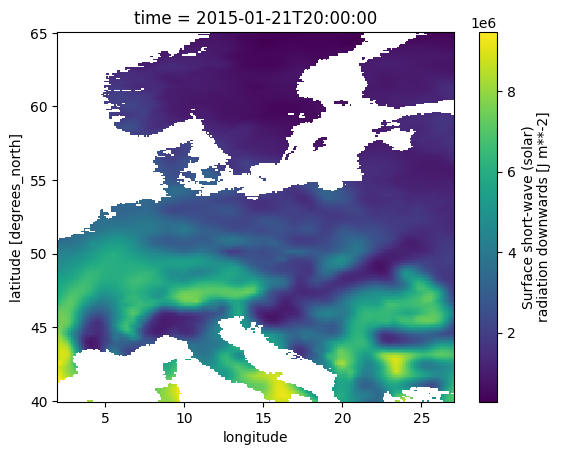

In [18]:
all1['ssrd'][500,:,:].plot()

In [19]:
all_resample = all1.resample(time="1800S").interpolate('linear')
all_resample = all_resample.isel(time=slice(0,17000))

In [20]:
all_resample.chunks

Frozen({'time': (17000,), 'latitude': (36, 51, 51, 51, 51, 11), 'longitude': (31, 51, 51, 51, 51, 16)})

In [21]:
%%time
# calculate the Rin and Rli difference for every hour
Rin = all1['ssrd'].diff("time")/3600  #xr.concat([all1['ssrd'].isel(time=0),all1['ssrd']], dim="time")
Rin[0::24] = all1['ssrd'][1::24]/3600 # assign the original values in t01
# Rin.mean(dim=['longitude','latitude']).compute()[48]
Rli = all1['strd'].diff("time")/3600  
Rli[0::24] = all1['strd'][1::24]/3600
# Rli.mean(dim=['longitude','latitude']).plot()
Rin = Rin.resample(time="1800S").interpolate('linear')
Rli = Rli.resample(time="1800S").interpolate('linear')
Rin

CPU times: user 106 ms, sys: 4.95 ms, total: 111 ms
Wall time: 109 ms


<xarray.DataArray 'ssrd' (time: 17517, latitude: 251, longitude: 251)>
dask.array<transpose, shape=(17517, 251, 251), dtype=float32, chunksize=(17517, 51, 51), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 65.0 64.9 64.8 64.7 ... 40.3 40.2 40.1 40.0
  * longitude  (longitude) float32 2.0 2.1 2.2 2.3 2.4 ... 26.7 26.8 26.9 27.0
  * time       (time) datetime64[ns] 2015-01-01T01:00:00 ... 2015-12-31T23:00:00

In [22]:
Rin.chunks

((17517,), (36, 51, 51, 51, 51, 11), (31, 51, 51, 51, 51, 16))

In [23]:
all1.nbytes/2**30

16.447633884847164

In [24]:
### 1) read LAI data
lai = xr.open_dataset(inputData+"/2015global/lai/LAI_global2015_10km.nc",chunks={"latitude":51, "longitude":51})['LAI']

In [25]:
lai = lai.sel(
    latitude=era5.latitude,  
    longitude=era5.longitude,
    method='nearest', tolerance=0.01
)

In [26]:
lai.chunks

((27,), (36, 51, 51, 51, 51, 11), (25, 51, 51, 51, 51, 22))

In [27]:
lai = lai.resample(time="1800S").interpolate('linear')

In [28]:
### 2) read canopy height data
hc_path = inputData+year+'/canopy_height/canopy_height_11kmEurope20230921_10km.nc'
hc = xr.open_dataset(hc_path,chunks={"y":51, "x":51}).rename({'x':'longitude','y':'latitude'})['__xarray_dataarray_variable__']

In [29]:
hc

<xarray.DataArray '__xarray_dataarray_variable__' (band: 1, latitude: 469,
                                                   longitude: 1002)>
dask.array<open_dataset-1259388f265ffa9f175e5fdd1486126d__xarray_dataarray_variable__, shape=(1, 469, 1002), dtype=float32, chunksize=(1, 51, 51), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -31.2 -31.1 -31.0 -30.9 ... 68.7 68.8 68.9
  * latitude   (latitude) float32 81.8 81.7 81.6 81.5 ... 35.3 35.2 35.1 35.0
  * band       (band) int64 1
Attributes:
    scales:         1.0
    offsets:        0.0
    descriptions:   b1
    AREA_OR_POINT:  Area
    grid_mapping:   spatial_ref

In [30]:
hc = hc.sel(
    latitude=era5.latitude,  
    longitude=era5.longitude,
    method='nearest', tolerance=0.01
)
hc

<xarray.DataArray '__xarray_dataarray_variable__' (band: 1, latitude: 251,
                                                   longitude: 251)>
dask.array<getitem, shape=(1, 251, 251), dtype=float32, chunksize=(1, 51, 51), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 2.0 2.1 2.2 2.3 2.4 ... 26.7 26.8 26.9 27.0
  * latitude   (latitude) float32 65.0 64.9 64.8 64.7 ... 40.3 40.2 40.1 40.0
  * band       (band) int64 1
Attributes:
    scales:         1.0
    offsets:        0.0
    descriptions:   b1
    AREA_OR_POINT:  Area
    grid_mapping:   spatial_ref

In [31]:
hc.chunks

((1,), (36, 51, 51, 51, 51, 11), (25, 51, 51, 51, 51, 22))

In [32]:
### 3) read CO2 data
## resampled CO2
ds_co2_10km = xr.open_dataset(inputData+year+"/co2/CAMS_CO2_2015_10km.nc",chunks={"latitude":51, "longitude":51})['co2']
ds_co2_10km = ds_co2_10km.sel(
    latitude=era5.latitude,  
    longitude=era5.longitude,
    method='nearest', tolerance=0.01
)

In [33]:
ds_co2_10km = ds_co2_10km.resample(time="1800S").interpolate('linear')

In [34]:
ds_co2_10km.chunks

((17515,), (36, 51, 51, 51, 51, 11), (25, 51, 51, 51, 51, 22))

In [35]:
### 4) read the resampled SSM data
## netcdf file works well
path_SSM = glob.glob(inputData+year+"/ssm/SM2015Europe11kmEurope20230921_10km.nc")[0]
ds_SSM = xr.open_dataset(path_SSM,chunks={"latitude":51, "longitude":51})['__xarray_dataarray_variable__'].rename('SSM')
# ds_SSM = ds_SSM.sortby(["longitude", "latitude"])
ds_SSM = ds_SSM.sel(
    latitude=era5.latitude,  
    longitude=era5.longitude,
    method='nearest', tolerance=0.01
)
SSM = ds_SSM.resample(time="1800S").interpolate('linear')/1000 

In [36]:
SSM.chunks

((17473,), (36, 51, 51, 51, 51, 11), (25, 51, 51, 51, 51, 22))

In [37]:
### 5) read Vcmax data
ds_Vcmo = xr.open_dataset(inputData+year+"/vcmax/TROPOMI_Vmax_Tg_mean10km_global.nc",chunks={"y":51, "x":51}).rename({'x':'longitude','y':'latitude'})['__xarray_dataarray_variable__']

In [38]:
ds_Vcmo

<xarray.DataArray '__xarray_dataarray_variable__' (band: 1, latitude: 1801,
                                                   longitude: 3600)>
dask.array<open_dataset-a639ca43cc3a701066f7ccb4ef55c3eb__xarray_dataarray_variable__, shape=(1, 1801, 3600), dtype=float32, chunksize=(1, 51, 51), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * latitude   (latitude) float32 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * band       (band) int64 1
Attributes:
    scales:         1.0
    offsets:        0.0
    AREA_OR_POINT:  Area
    grid_mapping:   spatial_ref

In [39]:
ds_Vcmo = ds_Vcmo.sel(
    latitude=era5.latitude,  
    longitude=era5.longitude,
    method='nearest', tolerance=0.01
)

In [40]:
ds_Vcmo.chunks 

((1,), (5, 51, 51, 51, 51, 42), (17, 51, 51, 51, 51, 30))

## why the chunks of ds_Vcmo and landcover after sel function is different from the above variables? because TROPOMI_Vmax_Tg_mean10km_global.nc is global? maybe we should load the data and select the roi, and then chunks?
but we will do the following later, so maybe it is okay like this, only ds_Vcmo and landcover has this problems?

hc=hc.chunk({"latitude":51, "longitude":51}).squeeze()

ds_Vcmo = ds_Vcmo.chunk({"latitude":51, "longitude":51}).squeeze()

landcover = landcover.chunk({"latitude":51, "longitude":51}).squeeze()

In [41]:
### 6) read IGBP data
# read lan
path_landcover = inputData+year+"/igbp/landcover10km_global.nc"
# landcover = xr.open_rasterio(path_landcover, engine="rasterio", chunks="auto").rename({'x':'longitude','y':'latitude'})
landcover = xr.open_dataset(path_landcover, chunks={"y":51, "x":51}).rename({'x':'longitude','y':'latitude'})['lccs_class']
landcover = landcover.sel(
    latitude=era5.latitude,  
    longitude=era5.longitude,
    method='nearest', tolerance=0.01
)

In [42]:
landcover.chunks

((1,), (5, 51, 51, 51, 51, 42), (17, 51, 51, 51, 51, 30))

In [43]:
# read IGBP unique values
data = pd.read_csv(inputData+'IGBP11unique.csv')['0'].unique()
# read the table for converting landcover to IGBP
IGBP_table = pd.read_csv(inputData+year+"/igbp/lccs_to_igbp_table.csv")

In [44]:
def landcover_to_igbp(landcover, IGBP_table, data):
    IGBP = np.vectorize(IGBP_table.set_index("lccs_class").T.to_dict('records')[0].get)(landcover.values)
    IGBP_all = pd.DataFrame(columns=['IGBP_veg_long1', 'IGBP_veg_long2', 'IGBP_veg_long3','IGBP_veg_long4','IGBP_veg_long5',
                              'IGBP_veg_long6','IGBP_veg_long7','IGBP_veg_long8','IGBP_veg_long9',
                             'IGBP_veg_long10','IGBP_veg_long11'])
    # define one hot encoding for IGBP
    encoder = OneHotEncoder(categories=[data]*1,sparse=False,
                           handle_unknown = "ignore")
    # transform data
    aa = encoder.fit_transform(IGBP.reshape(IGBP.shape[0]*IGBP.shape[1],1))
    # assign 23-D IGBP into 23 columns
    for i in range(1,12,1):
        IGBP_all['IGBP_veg_long'+str(i)] = aa[:,i-1]
    return IGBP_all

## 4) chunk all the input variables

In [45]:
ds_era5land = all_resample#.sel(time=t, method='nearest')#.compute()

ds_ss = xr.Dataset()
ds_ss["Rin"] = Rin.isel(time=slice(0,17000))#.chunk({"latitude": len(hc.latitude), "longitude": len(hc.longitude)})
ds_ss["Rli"] = Rli.isel(time=slice(0,17000))#.chunk({"latitude": len(hc.latitude), "longitude": len(hc.longitude)})
ds_ss["p"] = all_resample["sp"]/100#.chunk({"latitude": len(hc.latitude), "longitude": len(hc.longitude)})   # Pa -> hPa
ds_ss["Ta"] = all_resample["t2m"]- 273.15 #.chunk({"latitude": len(hc.latitude), "longitude": len(hc.longitude)})   # K -> degC
ds_ss["ea"] = vc.calculate_es(all_resample["d2m"] - 273.15)#.chunk({"latitude": len(hc.latitude), "longitude": len(hc.longitude)})
ds_ss["u"] = (all_resample["u10"] ** 2 + all_resample["v10"] ** 2) ** 0.5
# ds_ss["u"] = (all_resample["u10"].chunk({"latitude": len(hc.latitude), "longitude": len(hc.longitude)}) ** 2 + all_resample["v10"].chunk({"latitude": len(hc.latitude), "longitude": len(hc.longitude)}) ** 2) ** 0.5
ds_ss["Precip_msr"] = all_resample["tp"]*1000 #.chunk({"latitude": len(hc.latitude), "longitude": len(hc.longitude)})  # mm
ds_ss['LAI'] = lai#.chunk()
ds_ss['CO2'] = ds_co2_10km#.chunk()
ds_ss['SSM'] = SSM#.chunk()

ds_ss = ds_ss.assign_coords({"longitude": hc.longitude.values, "latitude": hc.latitude.values})
ds_Vcmo = ds_Vcmo.assign_coords({"longitude": hc.longitude.values, "latitude": hc.latitude.values})
landcover = landcover.assign_coords({"longitude": hc.longitude.values, "latitude": hc.latitude.values})

ds_ss = ds_ss.isel(time=slice(0,17000))


In [46]:
ds_ss

<xarray.Dataset>
Dimensions:     (latitude: 251, longitude: 251, time: 17000)
Coordinates:
  * latitude    (latitude) float32 65.0 64.9 64.8 64.7 ... 40.3 40.2 40.1 40.0
  * longitude   (longitude) float32 2.0 2.1 2.2 2.3 2.4 ... 26.7 26.8 26.9 27.0
  * time        (time) datetime64[ns] 2015-01-01T01:00:00 ... 2015-12-21T04:3...
Data variables:
    Rin         (time, latitude, longitude) float32 dask.array<chunksize=(17000, 36, 31), meta=np.ndarray>
    Rli         (time, latitude, longitude) float32 dask.array<chunksize=(17000, 36, 31), meta=np.ndarray>
    p           (time, latitude, longitude) float32 dask.array<chunksize=(17000, 36, 31), meta=np.ndarray>
    Ta          (time, latitude, longitude) float32 dask.array<chunksize=(17000, 36, 31), meta=np.ndarray>
    ea          (time, latitude, longitude) float32 dask.array<chunksize=(17000, 36, 31), meta=np.ndarray>
    u           (time, latitude, longitude) float32 dask.array<chunksize=(17000, 36, 31), meta=np.ndarray>
    Precip_msr  (time, latitude, longitude) float32 dask.array<chunksize=(17000, 36, 31), meta=np.ndarray>
    LAI         (time, latitude, longitude) float32 dask.array<chunksize=(17000, 36, 25), meta=np.ndarray>
    CO2         (time, latitude, longitude) float32 dask.array<chunksize=(17000, 36, 25), meta=np.ndarray>
    SSM         (time, latitude, longitude) float32 dask.array<chunksize=(17000, 36, 25), meta=np.ndarray>

In [47]:
ds_ss['p'].chunks

/home/qiahan/.local/lib/python3.9/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 20 entries) hit.
Flushing oldest 4 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


((17000,), (36, 51, 51, 51, 51, 11), (31, 51, 51, 51, 51, 16))

In [48]:
ds_Vcmo.chunks

((1,), (5, 51, 51, 51, 51, 42), (17, 51, 51, 51, 51, 30))

In [49]:
ds_ss.nbytes/2**30

39.898620925843716

## 5) predict fluxes with map_blocks

In [50]:
ds_ss = ds_ss.to_array()

In [51]:
ds_ss = ds_ss.chunk({"time":1000, "variable":10, "latitude":51, "longitude":51})

In [52]:
ds_ss.chunks

((10,),
 (1000,
  1000,
  1000,
  1000,
  1000,
  1000,
  1000,
  1000,
  1000,
  1000,
  1000,
  1000,
  1000,
  1000,
  1000,
  1000,
  1000),
 (51, 51, 51, 51, 47),
 (51, 51, 51, 51, 47))

In [53]:
hc=hc.chunk({"latitude":51, "longitude":51}).squeeze()
ds_Vcmo = ds_Vcmo.chunk({"latitude":51, "longitude":51}).squeeze()
landcover = landcover.chunk({"latitude":51, "longitude":51}).squeeze()

In [54]:
landcover.chunks

/home/qiahan/.local/lib/python3.9/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 20 entries) hit.
Flushing oldest 4 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


((51, 51, 51, 51, 47), (51, 51, 51, 51, 47))

In [55]:
chunks = [ds_ss.chunksizes[v] for v in ['time', 'latitude', 'longitude']]
chunks.append((7,))

In [56]:
estimated_LEH = xr.DataArray(
    name = 'LEH',
    data=dask.array.zeros((len(ds_ss.time), len(ds_ss.latitude), len(ds_ss.longitude),7), chunks=chunks),
    dims=("time", "latitude", "longitude","variable_out"),
    coords={
        "variable_out":range(7), 
        "time":ds_ss.time, 
        "latitude":ds_ss.latitude,
        "longitude":ds_ss.longitude
    }
)

In [57]:
def predictFlux(ds_ss, hc, ds_Vcmo, landcover, IGBP_table, training_testing_append, path_model):
    # ds_ss = ds_ss.reshape(10,-1)
    # time = ds_ss.time
    # ds_ss = ds_ss.squeeze("time")
    hc = hc.sel(latitude=ds_ss.latitude, longitude=ds_ss.longitude)
    hc_line = np.tile(hc.to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size) #如果和动态变量一样放进ds_ss里显示为一些离散的点，不知道为什么，所以静态变量放在时间循环外面
    print(hc_line.shape)
    ds_Vcmo = ds_Vcmo.sel(latitude=ds_ss.latitude, longitude=ds_ss.longitude)
    Vcmo_line = np.tile(ds_Vcmo.to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    landcover = landcover.sel(latitude=ds_ss.latitude, longitude=ds_ss.longitude)
    IGBP_all = landcover_to_igbp(landcover, IGBP_table, training_testing_append)
    IGBP1 = np.tile(IGBP_all.iloc[:,0].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP2 = np.tile(IGBP_all.iloc[:,1].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP3 = np.tile(IGBP_all.iloc[:,2].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP4 = np.tile(IGBP_all.iloc[:,3].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP5 = np.tile(IGBP_all.iloc[:,4].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP6 = np.tile(IGBP_all.iloc[:,5].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP7 = np.tile(IGBP_all.iloc[:,6].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP8 = np.tile(IGBP_all.iloc[:,7].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP9 = np.tile(IGBP_all.iloc[:,8].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP10 = np.tile(IGBP_all.iloc[:,9].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP11 = np.tile(IGBP_all.iloc[:,10].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    
    
    Rin_line = ds_ss[0,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    Rli_line = ds_ss[1,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    p_line = ds_ss[2,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    Ta_line = ds_ss[3,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    ea_line = ds_ss[4,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    u_line = ds_ss[5,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    Precip_msr_line = ds_ss[6,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    LAI_line = ds_ss[7,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    CO2_line = ds_ss[8,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    SSM_line = ds_ss[9,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)

    features_arr = np.concatenate((Rin_line, Rli_line, p_line, Ta_line,ea_line, u_line, Precip_msr_line,
                                   LAI_line, hc_line, CO2_line, SSM_line, Vcmo_line,
                                   IGBP1, IGBP2, IGBP3,IGBP4,IGBP5,IGBP6,IGBP7,IGBP8,IGBP9,IGBP10,IGBP11))
    features_arr = features_arr.transpose()
    # Nan value.
    df_features = pd.DataFrame(data=features_arr)
    df_features_drop_nan = df_features.dropna()
    invalid_index = sorted(set(df_features.index.to_list()) - set(df_features_drop_nan.index.to_list()))

    # # Convert the nan value as 0 for the calculation
    where_are_NaNs = np.isnan(features_arr)
    features_arr[where_are_NaNs] = 0
    
    model = load_model(path_model)
    
    # model = path_model
    features_arr1 = pd.DataFrame(data=features_arr)
    features_arr1.columns = ['Rin', 'Rli', 'p', 'Ta', 'ea', 'u', 'Precip_msr','LAI','hc','CO2','SSM','Vcmo',
            'IGBP_veg_long1','IGBP_veg_long2','IGBP_veg_long3','IGBP_veg_long4','IGBP_veg_long5','IGBP_veg_long6','IGBP_veg_long7','IGBP_veg_long8',
            'IGBP_veg_long9','IGBP_veg_long10','IGBP_veg_long11']
    estimated_LEH = model.predict(features_arr1)
    estimated_LEH[invalid_index] = np.nan
    LEH_map = estimated_LEH.reshape(ds_ss.time.size, ds_ss.latitude.size, ds_ss.longitude.size,7)
    
    return xr.DataArray(
        name = 'LEH',
        data=LEH_map,
        dims=("time", "latitude", "longitude","variable_out"),
        coords={
            "variable_out":range(7), 
            "time":ds_ss.time, 
            "latitude":ds_ss.latitude,
            "longitude":ds_ss.longitude
        }
    )
result = xr.map_blocks(
    predictFlux,
    ds_ss,
    args=[hc, ds_Vcmo, landcover],
    kwargs={"IGBP_table":IGBP_table, "training_testing_append":data, "path_model":workingPath+'3RF_train/RFLEH-LAI-hc-CO2-SSM-Vcmo-IGBP_multi7_1core_snellius0629.pkl'},
    template=estimated_LEH,
)

In [58]:
result

<xarray.DataArray 'LEH' (time: 17000, latitude: 251, longitude: 251,
                         variable_out: 7)>
dask.array<<this-array>-predictFlux, shape=(17000, 251, 251, 7), dtype=float64, chunksize=(1000, 51, 51, 7), chunktype=numpy.ndarray>
Coordinates:
  * variable_out  (variable_out) int64 0 1 2 3 4 5 6
  * time          (time) datetime64[ns] 2015-01-01T01:00:00 ... 2015-12-21T04...
  * latitude      (latitude) float64 65.0 64.9 64.8 64.7 ... 40.3 40.2 40.1 40.0
  * longitude     (longitude) float64 2.0 2.1 2.2 2.3 ... 26.7 26.8 26.9 27.0

In [59]:
start_time = time.time()  # Record the start time
result1 = result.compute()
end_time = time.time()  # Record the end time
total_running_time = end_time - start_time
print("Total Running Time:", total_running_time)

/home/qiahan/.conda/envs/firstEnv/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/qiahan/.conda/envs/firstEnv/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/qiahan/.conda/envs/firstEnv/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/qiahan/.conda/envs/firstEnv/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse

Total Running Time: 1408.8858819007874


In [61]:
result1

<xarray.DataArray 'LEH' (time: 17000, latitude: 251, longitude: 251,
                         variable_out: 7)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * variable_out  (variable_out) int64 0 1 2 3 4 5 6
  * time          (time) datetime64[ns] 2015-01-01T01:00:00 ... 2015-12-21T04...
  * latitude      (latitude) float64 65.0 64.9 64.8 64.7 ... 40.3 40.2 40.1 40.0
  * longitude     (longitude) float64 2.0 2.1 2.2 2.3 ... 26.7 26.8 26.9 27.0

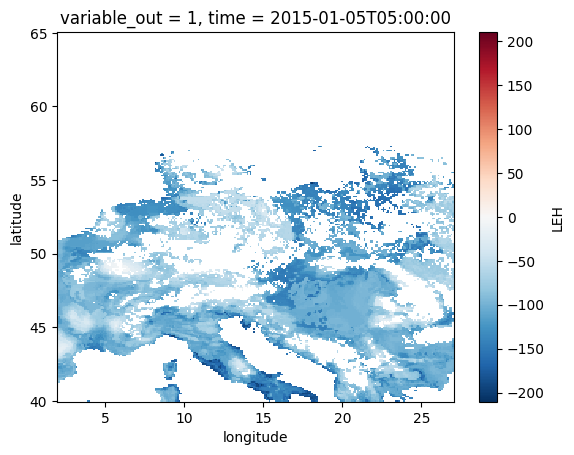

In [67]:
result1[200,:,:,1].plot() 

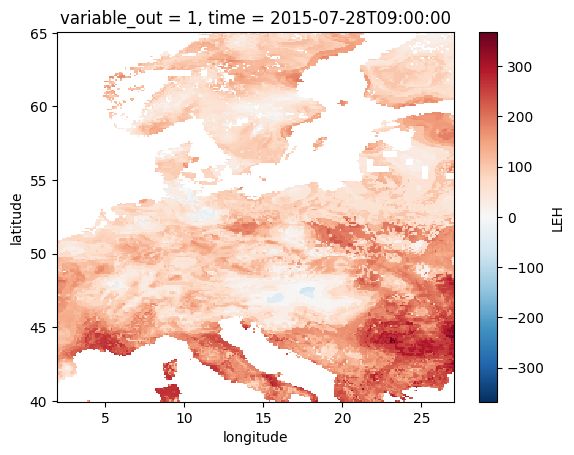

In [66]:
result1[10000,:,:,1].plot() 

In [147]:
np.nanmean(np.nanmean(result1[:,:,:,1],axis=(1,2)))

/scratch-local/qiahan.4000644/ipykernel_3353981/338425398.py:1: RuntimeWarning: Mean of empty slice
  np.nanmean(np.nanmean(result1[:,:,:,1],axis=(1,2)))


-51.39410622595279

In [134]:
result1[:,:,:,1]

<xarray.DataArray 'LEH' (time: 17000, latitude: 151, longitude: 151)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
    variable_out  int64 1
  * time          (time) datetime64[ns] 2015-01-01T01:00:00 ... 2015-12-21T04...
  * latitude      (latitude) float64 55.0 54.9 54.8 54.7 ... 40.3 40.2 40.1 40.0
  * longitude     (longitude) float64 2.0 2.1 2.2 2.3 ... 16.7 16.8 16.9 17.0

## export the result